In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from praatio import tgio
import os
import matplotlib.pyplot as plot

from scipy.io import wavfile


import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps

import os

from Signal_Analysis.features import signal


from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier


import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

import math
from python_speech_features import mfcc, logfbank



def print_stats(duration_mp):

    duration_ls = [(y, x) for (x, y) in duration_mp.items()]

    duration_ls.sort()

    duration_ls.reverse()

    for labelStat in duration_ls:
        print("Label " + labelStat[1] + " ; Total duration: " + str(round(labelStat[0], 2)) + " seconds")
        
        
        
        
        
##VAD using short term energy

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
 
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    orig_energy = energy
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return orig_energy, energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()



def extract_features(soundData, samplingFrequency):

    soundData = np.array(soundData, dtype="float")
       #--------Energy----------------
    energy = librosa.feature.rms(y=soundData)
    
        #------melspectogram----------
#     mel_spectrum = librosa.feature.melspectrogram(y=soundData, sr=samplingFrequency, center=False, 
#                                                   n_mels=40,hop_length=hopLength)
        #-------MFCC------------------
#     mfcc= librosa.feature.mfcc(y=soundData,sr=samplingFrequency, n_mfcc=13, hop_length=hopLength)
        #--------Spec Centroid---------
    spec_centr = librosa.feature.spectral_centroid(y=soundData)
        #--------Spec_bandwidth--------
    spec_bandwidth = librosa.feature.spectral_bandwidth(y = soundData)
        #--------Spec_contrast---------
    spec_contrast = librosa.feature.spectral_contrast(y = soundData)
        #------Spec Rolloff--------------
    spec_rolloff = librosa.feature.spectral_rolloff(y=soundData, roll_percent=0.80)
        #------Tonal Centroid------------
    #tonal_centroid = librosa.feature.tonnetz(y=t['data'], sr=t['FS'])
        #------ZCR---------------------
    zcr = librosa.zero_crossings(y=soundData)
    zcr = (np.nonzero(zcr)[0].shape[0])
    print ("zcr", zcr)
    
    ##Other Features
    
    fourier_transform = np.fft.rfft(soundData)
    
    print(soundData)

    abs_fourier_transform = np.abs(fourier_transform)

    power_spectrum = np.square(abs_fourier_transform)
    
#     print(fourier_transform)

    frequency = np.linspace(0, samplingFrequency/2, len(power_spectrum))
    
    ##Calculate the features for cough
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        
        if frequency[i]>0 and frequency[i]<=8000:
            low_sp += power_spectrum[i]
        elif frequency[i]>8000:
            high_sp += power_spectrum[i]

    mean_power = sum(power_spectrum)/len(power_spectrum) 
    power_below16 = low_sp
    power_above16 = high_sp
#     print(power_spectrum)
    
    ##Speech features
    ##Calculate the ratio of (base + first harmonic energy) to total energy
    max_power = max(power_spectrum)
    print(max_power)
    print(np.argmax(power_spectrum))
    base_frequency = frequency[np.argmax(power_spectrum)]
    print (f"Maximum power is {max_power} at frequency {base_frequency}")
    first_harmonic_frequency = 2*base_frequency

    if first_harmonic_frequency not in frequency.tolist():
        first_harmonic_frequency = min(frequency.tolist(),key=lambda x:abs(x-first_harmonic_frequency))
          
    power_at_harmonic = power_spectrum[frequency.tolist().index(first_harmonic_frequency)]
    print (f"Power at first harmonic is {power_at_harmonic} at frequency {first_harmonic_frequency}")
    power_ratio = (max_power+power_at_harmonic)/sum(power_spectrum)
    
    ##VAD
    
    STenergy, energy2, vad, voiced = naive_frame_energy_vad(soundData, samplingFrequency, threshold=-35,
                                                     win_len=1, win_hop=1)
    
    
    ##Mask features
    ##energy ratio between 0–1 and 1–8 kHz (LH1000)
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        if frequency[i]>0 and frequency[i]<=1000:
            low_sp += power_spectrum[i]
        elif frequency[i]>1000 and frequency[i]<=25000:
            high_sp += power_spectrum[i]
            
    print ("Energy in 0 Hz - 1 kHz", low_sp)
    print ("Energy in 1 kHz - 8 kHz", high_sp)
    print ("energy ratio between 0–1 and 1–8 kHz (LH1000)", low_sp/high_sp)
    LH_ratio = low_sp/high_sp
    
    ## HNR
    
    HNR = signal.get_HNR( soundData, samplingFrequency )
    
    fb_feat = logfbank(soundData, samplingFrequency, winlen=0.5, winstep=0.5, nfilt=26, nfft=32768)
#     fb_feat = fb_feat.T
    print(fb_feat[0].shape)
    fb1 = fb_feat[0]
    print("Filter bank: ", fb_feat.shape)
#     plt.matshow(fb_feat)
    fb_beat_1 = fb_feat.flatten()
## index - feature
#     0 - energy      
#     1 - mel_spectrum (40, 12)
#     2 - mfcc (13, 16)
#     3 - spec_centr (1, 12)
#     4 - spec_bandwidth (1, 12)
#     5 - spec_contrast (7, 12)
#     6 - spec_rolloff (1, 12)
#     7 - zcr 
#     8 - mean_power  
#     9 - power_below16
#     10 - power_above16
#     11 - base_frequency
#     12 - power_ratio
#     13 - STenergy
#     14 - LH_ratio
#     15 - HNR
#     features = [np.average(energy), mel_spectrum, mfcc, spec_centr, spec_bandwidth, spec_contrast, spec_rolloff, zcr, mean_power,power_below16,power_above16, base_frequency, power_ratio, STenergy[0], LH_ratio, HNR] 
    features = [np.average(energy), spec_centr[0][0], spec_bandwidth[0][0],  spec_rolloff[0][0], zcr, mean_power, power_below16, power_above16, base_frequency, power_ratio, STenergy[0], LH_ratio, HNR] 

    for i in fb1:
        features.append(i)
    
    selected_features = []
#     for index in indices:
#         selected_features.append(features[index])

    non_privacy_features = abs_fourier_transform
    
    
    return features,selected_features,non_privacy_features

In [3]:
var = pd.read_csv('AIM_exp1_editted.csv')
var = var[25:]
var.head()

,Sample #,Start Date,Start Time,Sample Length,Averaging Interval (s),Title,Instrument ID,Instrument Errors,Conc Mean,Conc Min,Conc Max,Conc Std Dev
25,26,06/06/22,14:17:14,10,1,NaN,3775 71025228 2.16,None,0.8859,0.000,1.969,0.624020
26,27,06/06/22,14:17:25,10,1,NaN,3775 71025228 2.16,None,0.2364,0.000,0.788,0.229740
27,28,06/06/22,14:17:36,10,1,NaN,3775 71025228 2.16,None,0.1969,0.000,0.394,0.152467
28,29,06/06/22,14:17:47,10,1,NaN,3775 71025228 2.16,None,0.0197,0.000,0.197,0.059100
29,30,06/06/22,14:17:58,10,1,NaN,3775 71025228 2.16,None,0.5513,0.394,0.984,0.211748


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_98484/61590351.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10, axis='x')


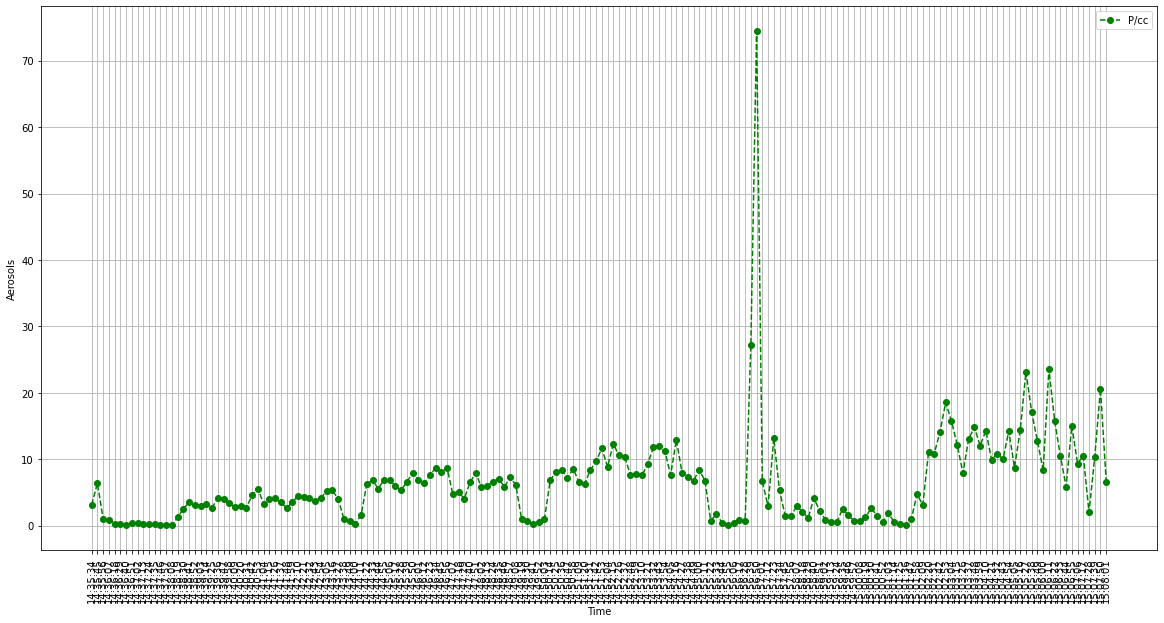

In [4]:
x = var['Start Time'][100:]
y = var['Conc Mean'][100:]

plt.figure(figsize=(20,10))
plt.plot(x, y , color = 'g', linestyle = 'dashed',
         marker = 'o',label = "P/cc")


plt.locator_params(nbins=10, axis='x')
plt.xticks(rotation = 90)
plt.xlabel('Time')
plt.ylabel('Aerosols')

plt.grid()
plt.legend()
plt.show()

In [5]:
y

125     3.16720
126     6.39260
127     1.04290
128     0.88570
129     0.23640
         ...   
298    10.52350
299     2.00630
300    10.38770
301    20.62260
302     6.59125
Name: Conc Mean, Length: 178, dtype: float64

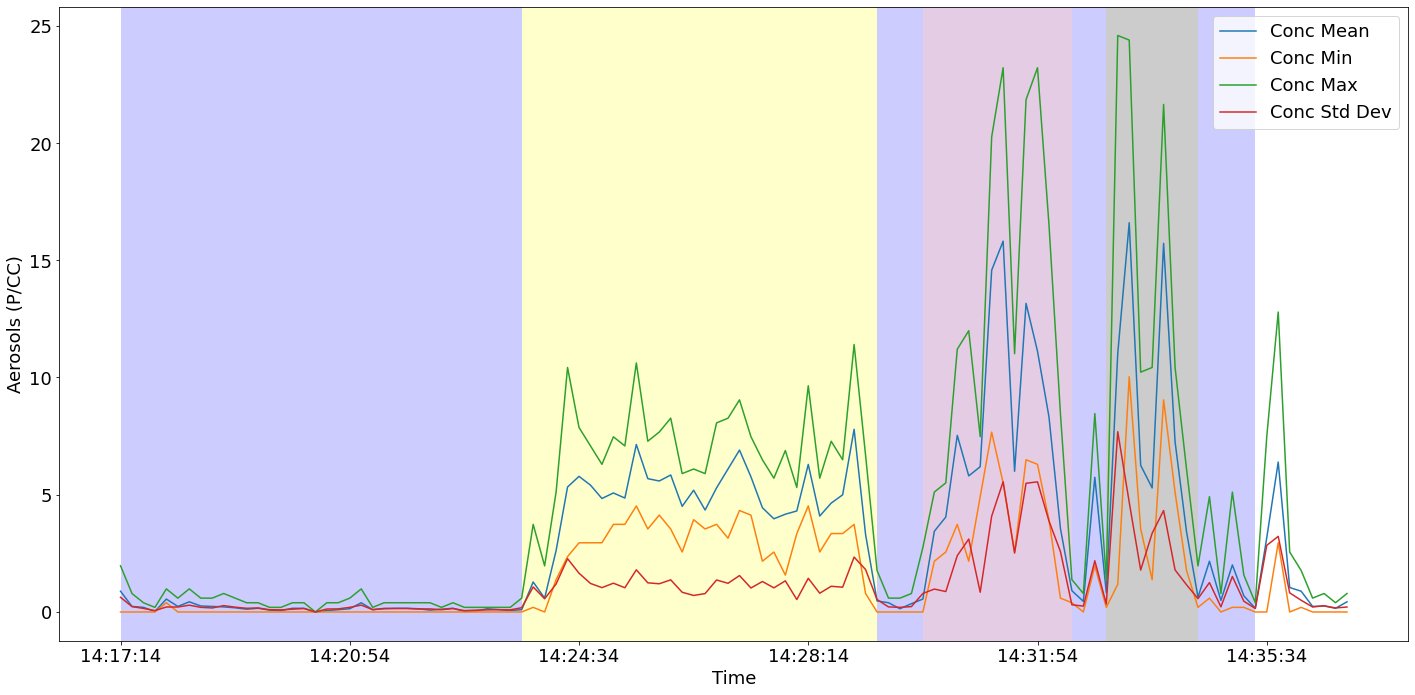

In [6]:

df = var[:108]
df_type = df
df = df.drop('Sample #', 1)
df = df.drop('Sample Length', 1)
df = df.drop('Averaging Interval (s)', 1)
df = df.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 35 , color='blue', alpha=0.2, lw=0)
plt.axvspan(35, 66 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(66, 70 , color='blue', alpha=0.2, lw=0)
plt.axvspan(70, 83 , color='purple', alpha=0.2, lw=0)
plt.axvspan(83, 86 , color='blue', alpha=0.2, lw=0)
plt.axvspan(86, 94 , color='black', alpha=0.2, lw=0)
plt.axvspan(94, 99 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_type.jpg')

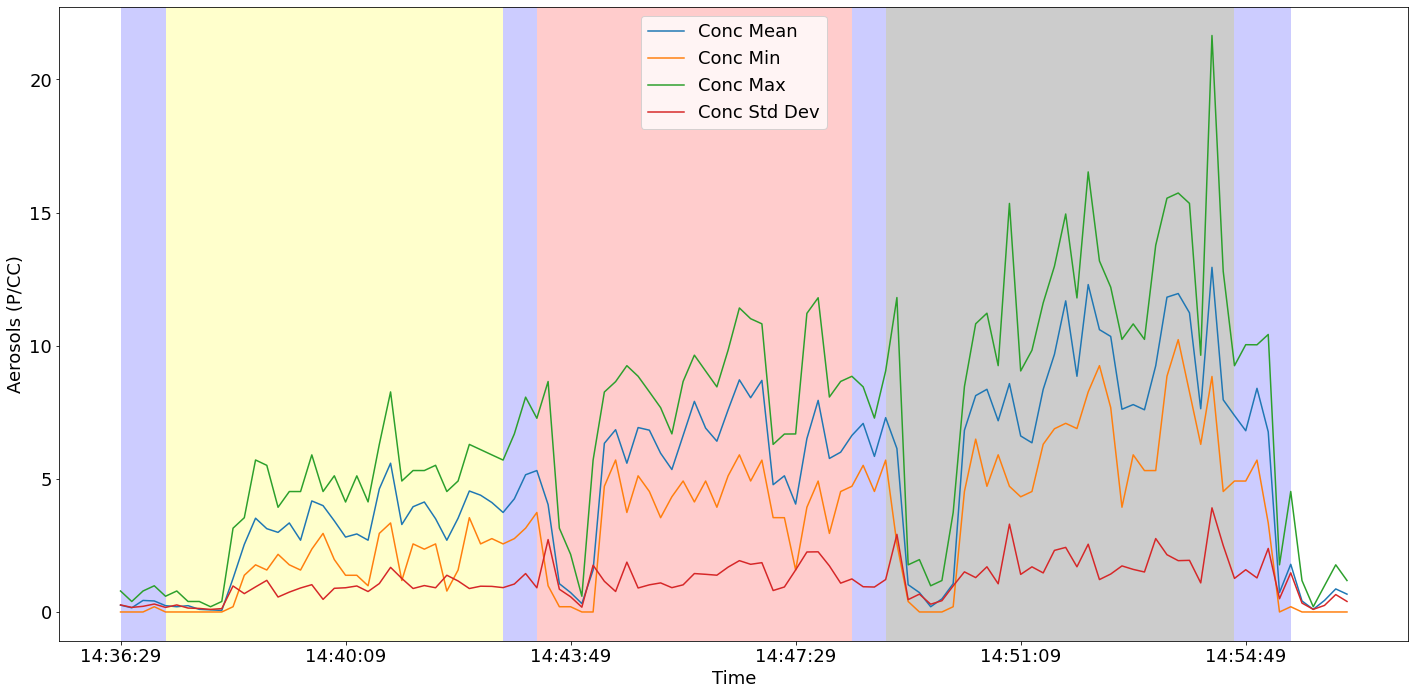

In [7]:


df2 = var[105:215]
df_level = df2
df2 = df2.drop('Sample #', 1)
df2 = df2.drop('Sample Length', 1)
df2 = df2.drop('Averaging Interval (s)', 1)
df2 = df2.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df2.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

plt.axvspan(0, 4 , color='blue', alpha=0.2, lw=0)
plt.axvspan(4, 34 , color='yellow', alpha=0.2, lw=0)
plt.axvspan(34, 37 , color='blue', alpha=0.2, lw=0)
plt.axvspan(37, 65 , color='red', alpha=0.2, lw=0)
plt.axvspan(65, 68 , color='blue', alpha=0.2, lw=0)
plt.axvspan(68, 99 , color='black', alpha=0.2, lw=0)
plt.axvspan(99, 104 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_level.jpg')

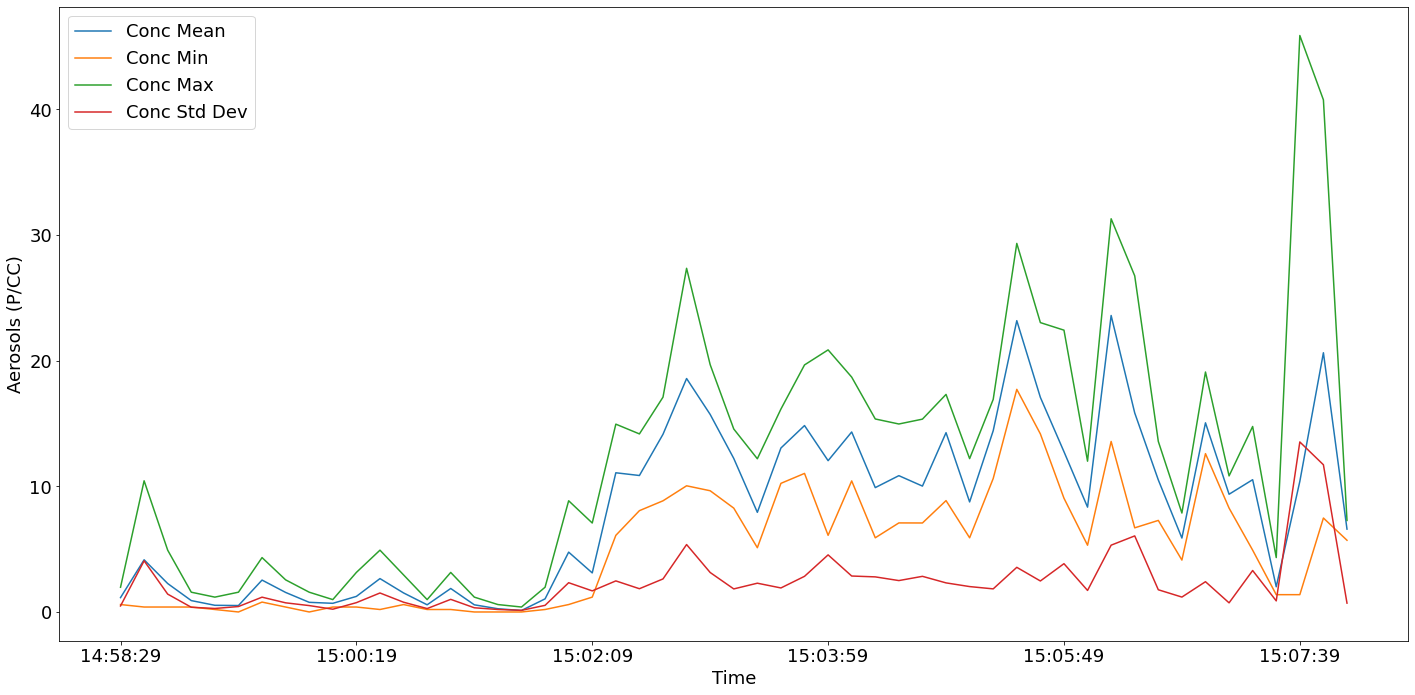

In [8]:

df3 = var[225:]
df3 = df3.drop('Sample #', 1)
df3 = df3.drop('Sample Length', 1)
df3 = df3.drop('Averaging Interval (s)', 1)
df3 = df3.drop('Title', 1)


# df = df[:-10]
# df.drop(df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")].index, inplace = True)
# df = df.drop(df.index[(df['Start Time'] > "13:48") & ( df['Start Time'] < "13:52")])
# df = df[(df['Start Time'] <= "13:48") & ( df['Start Time'] >= "13:52")]
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df3.set_index('Start Time').plot()
plt.ylabel('Aerosols (P/CC)')
plt.xlabel('Time')

# plt.axvspan(0, 106 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(106, 151 , color='yellow', alpha=0.2, lw=0)
# plt.axvspan(151, 160 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(160, 221 , color='red', alpha=0.2, lw=0)
# plt.axvspan(221, 237 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(237, 294 , color='black', alpha=0.2, lw=0)
# plt.axvspan(294, 306 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(306, 316 , color='green', alpha=0.2, lw=0)
# plt.axvspan(316, 322 , color='blue', alpha=0.2, lw=0)
# plt.axvspan(322, 332 , color='orange', alpha=0.2, lw=0)


plt.savefig('aerosol_activities_graph.jpg')

In [9]:
import matplotlib.pyplot as plot

from scipy.io import wavfile

import statistics 
import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps
import math
import os

from Signal_Analysis.features import signal



# Read the wav file (mono)
def wav_plot(filename, m,n):
    WAV_FILE_NAME  = filename
    samplingFrequency, signalData = wavfile.read(WAV_FILE_NAME)
    
#     signalData = signalData[m:n]
    times = np.arange(len(signalData))/samplingFrequency
    print (len(times), times[-1])

    
    print(samplingFrequency)
    numchunks = 10
    chunks = np.array_split(signalData, numchunks)
    dbs = [20*math.log10( math.sqrt(statistics.mean(chunk**2)) ) for chunk in chunks]
    print ("average power", dbs)
    
    
    plt.figure(figsize=(20,7))

    # Plot the signal read from wav file

    plot.subplot(311)

    plot.title('Spectrogram of a wav file with air')



    plot.plot(times,signalData)

    plot.xlabel('Sample')

    plot.ylabel('Amplitude')



    plot.subplot(312)

    plot.specgram(signalData,Fs=samplingFrequency)

    plot.xlabel('Time')

    plot.ylabel('Frequency')
    

    plot.show()
    
    return samplingFrequency, signalData

(479620,)
zcr 5240
[-693. -846. -904. ... 1701. 1930. 2111.]
4.6361760407315014e+17
1199
Maximum power is 4.6361760407315014e+17 at frequency 119.9949960385305
Power at first harmonic is 1377210343794881.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1646323470290819e+18
Energy in 1 kHz - 8 kHz 1.0052811296978272e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.85140838952715
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 5025
[2270. 2414. 2575. ... 2266. 2095. 1872.]
3.983142621658808e+17
1199
Maximum power is 3.983142621658808e+17 at frequency 119.9949960385305
Power at first harmonic is 300608955473476.4 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1670322551352225e+18
Energy in 1 kHz - 8 kHz 9833546158068228.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.67867769936646
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 5100
[ 1641.  1429.  1202. ... -7519. -7351. -7202.]
3.500717910332682e+17
1199
Maximum power is 3.500717910332682e+17 at frequency 119.99499603853

(26,)
Filter bank:  (20, 26)
(479620,)
zcr 7601
[ 223.  202.  135. ... 4788. 4831. 4818.]
4.2261081588846925e+17
1199
Maximum power is 4.2261081588846925e+17 at frequency 119.9949960385305
Power at first harmonic is 1199949282941267.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.5925493182885243e+18
Energy in 1 kHz - 8 kHz 4.078958211425277e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.04304078987004
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 6990
[ 4716.  4586.  4466. ... -1963. -2041. -2143.]
3.3431529868877997e+17
1199
Maximum power is 3.3431529868877997e+17 at frequency 119.9949960385305
Power at first harmonic is 379599954674989.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.4423375189225638e+18
Energy in 1 kHz - 8 kHz 3.6153584312798776e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.89473094682787
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 7282
[-2292. -2470. -2626. ...  1694.  1843.  1879.]
3.076359888557217e+17
1199
Maximum power is 3.0763598885

Energy in 0 Hz - 1 kHz 1.366490291058116e+18
Energy in 1 kHz - 8 kHz 2.2949345356673464e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.543759084210784
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 5186
[-1232.  -919.  -590. ...  1671.  1688.  1773.]
4.753197577194269e+17
1199
Maximum power is 4.753197577194269e+17 at frequency 119.9949960385305
Power at first harmonic is 1629165089258010.2 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1510047304869059e+18
Energy in 1 kHz - 8 kHz 9938840308580542.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.80875582568763
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 5350
[ 1889.  1923.  1848. ... -1406. -1489. -1512.]
3.7679976887229485e+17
1199
Maximum power is 3.7679976887229485e+17 at frequency 119.9949960385305
Power at first harmonic is 528208290944658.44 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.0625396680449189e+18
Energy in 1 kHz - 8 kHz 1.0006021792051024e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.190021

(26,)
Filter bank:  (20, 26)
(479620,)
zcr 8810
[ 6202.  5941.  5655. ... -1336. -1194. -1100.]
3.130750461443412e+17
1199
Maximum power is 3.130750461443412e+17 at frequency 119.9949960385305
Power at first harmonic is 1133346117723631.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.7567128588120576e+18
Energy in 1 kHz - 8 kHz 7.50379554860403e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.410990443881
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 10385
[-1038. -1056. -1140. ... -3340. -3280. -3309.]
3.539375445859194e+17
1199
Maximum power is 3.539375445859194e+17 at frequency 119.9949960385305
Power at first harmonic is 139213306131686.05 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.1468901204748882e+18
Energy in 1 kHz - 8 kHz 1.382752302872976e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.526208967537032
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 9831
[-3370. -3414. -3466. ... -4850. -5011. -5161.]
4.716068219017986e+17
1199
Maximum power is 4.716068219

(26,)
Filter bank:  (20, 26)
(479620,)
zcr 5304
[ 2431.  2380.  2389. ... -2259. -2345. -2391.]
4.1841006315038496e+17
1199
Maximum power is 4.1841006315038496e+17 at frequency 119.9949960385305
Power at first harmonic is 492683933122170.8 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 1.1344116811816462e+18
Energy in 1 kHz - 8 kHz 9812129944410418.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.61319383340165
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 11209
[-2444. -2505. -2611. ... -5662. -5530. -5408.]
4.546149825084462e+17
1199
Maximum power is 4.546149825084462e+17 at frequency 119.9949960385305
Power at first harmonic is 1292352787613766.5 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 3.2807235999054295e+18
Energy in 1 kHz - 8 kHz 3.2999492989046995e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.941739410948976
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 11319
[-5258. -5149. -5030. ...  -786.  -951. -1186.]
4.338917686642089e+17
1199
Maximum power is 4.338917

Energy in 0 Hz - 1 kHz 2.802642721031439e+18
Energy in 1 kHz - 8 kHz 1.520869985244587e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.42789158983052
(26,)
Filter bank:  (20, 26)
(479620,)
zcr 10822
[ 4425.  4370.  4246. ... -1554. -1653. -1769.]
4.1618793306697043e+17
1199
Maximum power is 4.1618793306697043e+17 at frequency 119.9949960385305
Power at first harmonic is 1793806653394229.0 at frequency 239.989992077061
Energy in 0 Hz - 1 kHz 2.7710126998316616e+18
Energy in 1 kHz - 8 kHz 2.8278985627441827e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.798840511247619
(26,)
Filter bank:  (20, 26)
(479619,)
zcr 13600
[-1909. -2063. -2243. ...  2807.  3443.  3896.]
4.493459839490214e+17
1199
Maximum power is 4.493459839490214e+17 at frequency 119.99549641589766
Power at first harmonic is 932525513115973.2 at frequency 239.99099283179532
Energy in 0 Hz - 1 kHz 3.28906934338184e+18
Energy in 1 kHz - 8 kHz 4.569773577568988e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.197444

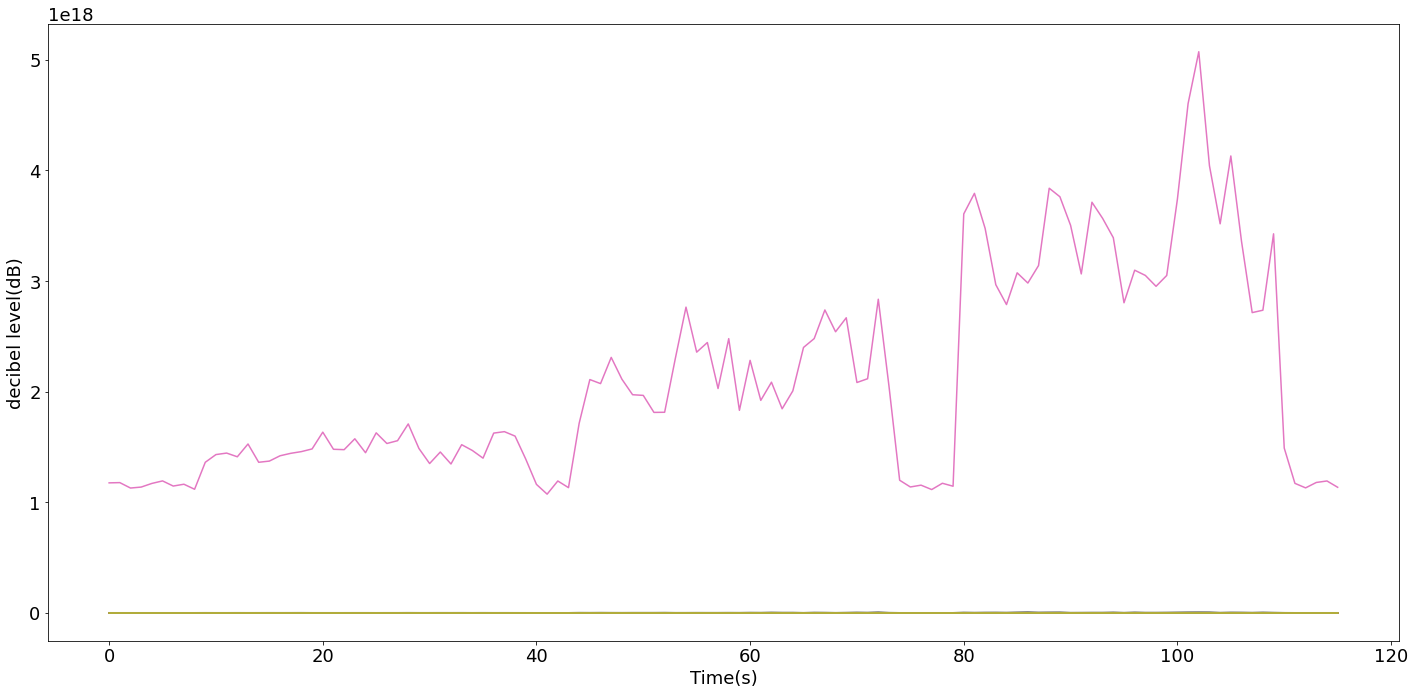

In [10]:
from scipy.io.wavfile import read
samprate, wavdata = read('0606_exp_actlevel.wav')
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs1 = []
WIDTH = 2

chunks = np.array_split(wavdata, 116)
for chunk in chunks:
    print(chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs1.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs1)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_actlevel.png")

(478834,)
zcr 5104
[-1622. -1486. -1302. ...  3605.  3362.  3200.]
4.760531120581478e+17
1197
Maximum power is 4.760531120581478e+17 at frequency 119.99147930180396
Power at first harmonic is 2576278690465810.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1915516846388114e+18
Energy in 1 kHz - 8 kHz 9898305238449814.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.37936353086458
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 4998
[ 3057.  2954.  2955. ... -1181. -1216. -1234.]
4.475240426609729e+17
1197
Maximum power is 4.475240426609729e+17 at frequency 119.99147930180396
Power at first harmonic is 1478577712678259.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1294272960986455e+18
Energy in 1 kHz - 8 kHz 9767670903914570.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.62913075275777
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 5314
[-1321. -1407. -1560. ...  1295.  1513.  1750.]
4.0267252883647366e+17
1197
Maximum power is 4.0267252883647366e+17 at frequency 

Energy in 0 Hz - 1 kHz 1.1255756572607328e+18
Energy in 1 kHz - 8 kHz 9909318619559924.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.5875937058849
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 5126
[-4728. -4892. -4999. ...  5293.  5375.  5442.]
3.2626937387512e+17
1197
Maximum power is 3.2626937387512e+17 at frequency 119.99147930180396
Power at first harmonic is 633464321458796.6 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1320990611696329e+18
Energy in 1 kHz - 8 kHz 9681230713419382.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.93751493809602
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 5127
[5432. 5335. 5228. ... 4489. 4626. 4785.]
3.096530839310258e+17
1197
Maximum power is 3.096530839310258e+17 at frequency 119.99147930180396
Power at first harmonic is 455401999398552.0 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 1.1626281576977917e+18
Energy in 1 kHz - 8 kHz 9587812243939096.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.2610476840265
(26,)
Fi

(26,)
Filter bank:  (20, 26)
(478834,)
zcr 9013
[-1078. -1169. -1277. ... -1063. -1640. -2369.]
3.205471125470137e+17
1197
Maximum power is 3.205471125470137e+17 at frequency 119.99147930180396
Power at first harmonic is 275525067611335.12 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.186264566351072e+18
Energy in 1 kHz - 8 kHz 9.14691753662717e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.901653836897214
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 9102
[-3145. -3850. -4449. ... -1449.  -281.   787.]
3.931572871733728e+17
1197
Maximum power is 3.931572871733728e+17 at frequency 119.99147930180396
Power at first harmonic is 1364052242156525.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.1078103540071468e+18
Energy in 1 kHz - 8 kHz 1.1990200037825898e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.579442772910916
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 9131
[1489. 1786. 1704. ... 2389. 2407. 2480.]
4.680791730351443e+17
1197
Maximum power is 4.6807917

Energy in 0 Hz - 1 kHz 3.0528169317198126e+18
Energy in 1 kHz - 8 kHz 1.342711608927415e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.73620717525831
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 10672
[-2201. -2451. -2138. ...   850.   778.   837.]
3.8291087752504026e+17
1197
Maximum power is 3.8291087752504026e+17 at frequency 119.99147930180396
Power at first harmonic is 97229069190772.88 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.6340123959319716e+18
Energy in 1 kHz - 8 kHz 1.2518397449152182e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.04113091656442
(26,)
Filter bank:  (20, 26)
(478834,)
zcr 9628
[859. 812. 813. ... 525. 130. -44.]
3.302224504656404e+17
1197
Maximum power is 3.302224504656404e+17 at frequency 119.99147930180396
Power at first harmonic is 1178213410538585.5 at frequency 239.98295860360793
Energy in 0 Hz - 1 kHz 2.437251814714708e+18
Energy in 1 kHz - 8 kHz 1.4580753315933814e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.715541110288

(26,)
Filter bank:  (20, 26)
(478833,)
zcr 6396
[ 1903.  1792.  1672. ... -1005.  -778.  -573.]
3.171305229246454e+17
1197
Maximum power is 3.171305229246454e+17 at frequency 119.9919804858489
Power at first harmonic is 355928634282160.0 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.3902077133505505e+18
Energy in 1 kHz - 8 kHz 1.7778179951317622e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.819741487359148
(26,)
Filter bank:  (20, 26)
(478833,)
zcr 7762
[-376. -125.  141. ... 3670. 3654. 3628.]
3.591672691163309e+17
1197
Maximum power is 3.591672691163309e+17 at frequency 119.9919804858489
Power at first harmonic is 534617237909106.9 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.510629967904126e+18
Energy in 1 kHz - 8 kHz 3.483759283188026e+17
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.336206508854228
(26,)
Filter bank:  (20, 26)
(478833,)
zcr 5027
[3531. 3400. 3301. ... 7096. 7022. 6930.]
4.246222199655147e+17
1197
Maximum power is 4.246222199655147e+17 

Energy in 0 Hz - 1 kHz 1.144249791275705e+18
Energy in 1 kHz - 8 kHz 9765450351133636.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.17327415861298
(26,)
Filter bank:  (20, 26)
(478833,)
zcr 4981
[5690. 5802. 6005. ... 2176. 2210. 2246.]
4.832289137154423e+17
1197
Maximum power is 4.832289137154423e+17 at frequency 119.9919804858489
Power at first harmonic is 738359132550877.1 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1610997585516623e+18
Energy in 1 kHz - 8 kHz 9825196342973202.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.17573084756309
(26,)
Filter bank:  (20, 26)
(478833,)
zcr 5029
[2286. 2403. 2544. ... 2115. 1849. 1630.]
4.253104664331783e+17
1197
Maximum power is 4.253104664331783e+17 at frequency 119.9919804858489
Power at first harmonic is 1641340811277572.8 at frequency 239.9839609716978
Energy in 0 Hz - 1 kHz 1.1621683390838272e+18
Energy in 1 kHz - 8 kHz 9727296354133786.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.47495961608523
(26,)
Filter

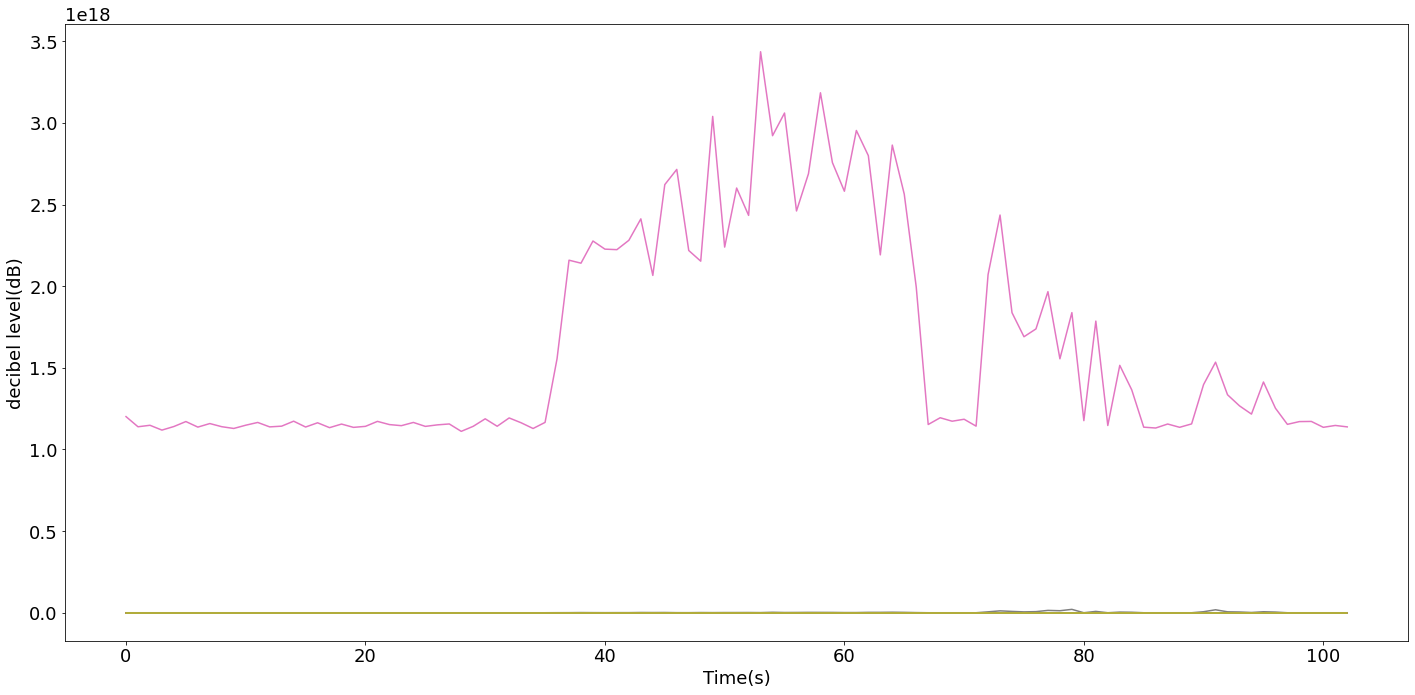

In [11]:
from scipy.io.wavfile import read
samprate, wavdata = read('0606_exp_activtype.wav')
import numpy as np
import math
import statistics 
# import pyaudio
import time
from math import log10
import audioop  
# basically taking a reading every half a second - the size of the data 
# divided by the sample rate gives us 1 second chunks so I chop 
# sample rate in half for half second chunks
dbs2 = []
WIDTH = 2

chunks = np.array_split(wavdata, 103)
for chunk in chunks:
    print (chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs2.append(a)
# print(dbs)
x = range(0,11600)
plt.plot(dbs2)
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_activtype.png")
print(len(dbs2))

210
(288302,)
zcr 5851
[-152. -180. -210. ...  -98. -124. -147.]
4510784780712634.0
721
Maximum power is 4510784780712634.0 at frequency 120.040790559899
Power at first harmonic is 89249280771257.23 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.8834009366656424e+16
Energy in 1 kHz - 8 kHz 1278929824237204.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.82156867575691
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 5900
[-137.  -99.  -68. ...  857.  875.  969.]
4607608041828092.0
721
Maximum power is 4607608041828092.0 at frequency 120.040790559899
Power at first harmonic is 33546153966762.316 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 6.265509821193741e+16
Energy in 1 kHz - 8 kHz 910297025059291.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.82929031637387
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 5478
[  861.   695.   793. ...  -914. -1274. -1529.]
5190198509155697.0
721
Maximum power is 5190198509155697.0 at frequency 120.040790559899
Power at first harmonic is 

Energy in 0 Hz - 1 kHz 1.0418041963690784e+17
Energy in 1 kHz - 8 kHz 3749803221569526.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.78290312346093
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 4879
[ 194.  108.   58. ... 8618. 8605. 8355.]
2648893778831504.0
721
Maximum power is 2648893778831504.0 at frequency 120.040790559899
Power at first harmonic is 73193382428062.06 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 9.333020944727432e+16
Energy in 1 kHz - 8 kHz 2078213946928562.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.90885531069073
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 6595
[7983. 7644. 7308. ... 1620. 1623. 1627.]
3382195105394591.5
721
Maximum power is 3382195105394591.5 at frequency 120.040790559899
Power at first harmonic is 22590379658212.094 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.3713265395595611e+17
Energy in 1 kHz - 8 kHz 6443135077184104.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.283529262262235
(26,)
Filter bank:  (13, 26)
(28

zcr 5631
[ 294.  258.  225. ... 1192. 1275. 1354.]
3648231376424561.0
721
Maximum power is 3648231376424561.0 at frequency 120.040790559899
Power at first harmonic is 99021685498534.27 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.5309935728747376e+17
Energy in 1 kHz - 8 kHz 3639832890524385.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.062194032599386
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 6119
[1438. 1499. 1525. ...  689.  640.  609.]
2768251892737304.0
721
Maximum power is 2768251892737304.0 at frequency 120.040790559899
Power at first harmonic is 19510362443582.51 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 9.514151551749491e+16
Energy in 1 kHz - 8 kHz 2622177646965895.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.28339812429663
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 5490
[ 604.  620.  628. ... -262. -290. -300.]
2325978217542819.5
721
Maximum power is 2325978217542819.5 at frequency 120.040790559899
Power at first harmonic is 10450034631322.395 

zcr 3740
[-1005. -1025. -1021. ...  1179.  1185.  1152.]
1701184225443480.2
721
Maximum power is 1701184225443480.2 at frequency 120.040790559899
Power at first harmonic is 16960075393182.27 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.2741623569847164e+16
Energy in 1 kHz - 8 kHz 366260060698750.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.39446880280289
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 6904
[1117. 1090. 1077. ... -121. -358. -316.]
2334354207759356.5
721
Maximum power is 2334354207759356.5 at frequency 120.040790559899
Power at first harmonic is 3192939986524.0215 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.5700764128484797e+17
Energy in 1 kHz - 8 kHz 6787148156789382.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.133080000292708
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 6695
[ -147.  -237.  -538. ... -1489. -1459. -1457.]
2697699994368634.5
721
Maximum power is 2697699994368634.5 at frequency 120.040790559899
Power at first harmonic is 119006

Energy in 0 Hz - 1 kHz 2.370374400450946e+17
Energy in 1 kHz - 8 kHz 8745045189229383.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.105341929740494
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 7839
[-1083. -1067. -1032. ... -1466. -1522. -1584.]
4166063005887081.5
721
Maximum power is 4166063005887081.5 at frequency 120.040790559899
Power at first harmonic is 10299853665857.107 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.6237172316720976e+17
Energy in 1 kHz - 8 kHz 6474237775330098.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.079666333220363
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 7300
[-1617. -1645. -1701. ...  1804.  1795.  1798.]
3868183958804303.0
721
Maximum power is 3868183958804303.0 at frequency 120.040790559899
Power at first harmonic is 250744915217309.97 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.3251285361264227e+17
Energy in 1 kHz - 8 kHz 9025038235524256.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.763087927697384
(26,)
Filter bank

Energy in 0 Hz - 1 kHz 1.5178174677588915e+17
Energy in 1 kHz - 8 kHz 4794515444360137.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.657369454181733
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 6299
[402. 410. 414. ... 589. 572. 439.]
3743393958653727.0
721
Maximum power is 3743393958653727.0 at frequency 120.040790559899
Power at first harmonic is 51376009072208.266 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.7829535016478966e+17
Energy in 1 kHz - 8 kHz 4317928437175878.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.2918724242227
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 6890
[ 343.  380.  478. ... -468. -422. -380.]
3669633840340661.0
721
Maximum power is 3669633840340661.0 at frequency 120.040790559899
Power at first harmonic is 9769154255724.58 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.480499028807442e+17
Energy in 1 kHz - 8 kHz 3497442492616081.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.33090413732668
(26,)
Filter bank:  (13, 26)
(288302,)
z

zcr 6995
[2173. 1826. 1450. ... 1310. 1325. 1330.]
3196621487354618.5
721
Maximum power is 3196621487354618.5 at frequency 120.040790559899
Power at first harmonic is 56333906102518.35 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 1.7194786492465178e+17
Energy in 1 kHz - 8 kHz 6603820023031902.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.03763644753423
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 7456
[1369. 1421. 1423. ... -436. -551. -678.]
3283020380698238.0
721
Maximum power is 3283020380698238.0 at frequency 120.040790559899
Power at first harmonic is 44282042841782.31 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 2.5252184093175907e+17
Energy in 1 kHz - 8 kHz 6911451740988647.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.53672924230491
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 7302
[-785. -834. -858. ... 2938. 2998. 3040.]
2813531963177052.5
721
Maximum power is 2813531963177052.5 at frequency 120.040790559899
Power at first harmonic is 6410776901050.608 a

Energy in 0 Hz - 1 kHz 3.096297714346192e+16
Energy in 1 kHz - 8 kHz 333328897189106.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.89016765292853
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 3901
[121.  90.  90. ... 413. 411. 408.]
2632580766342697.0
721
Maximum power is 2632580766342697.0 at frequency 120.040790559899
Power at first harmonic is 6562179641882.895 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.2056315071759028e+16
Energy in 1 kHz - 8 kHz 345870150966382.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.68309214366066
(26,)
Filter bank:  (13, 26)
(288302,)
zcr 3604
[ 381.  339.  302. ... -856. -869. -870.]
1867813494723842.2
721
Maximum power is 1867813494723842.2 at frequency 120.040790559899
Power at first harmonic is 8696875108649.585 at frequency 240.081581119798
Energy in 0 Hz - 1 kHz 3.218259112996992e+16
Energy in 1 kHz - 8 kHz 347343945338212.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.65338164634888
(26,)
Filter bank:  (13, 26)
(288302,)
zc

Energy in 0 Hz - 1 kHz 1.2112951389147294e+17
Energy in 1 kHz - 8 kHz 5141937459808315.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.557173699267143
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 5804
[-2409. -2428. -2454. ...  3453.  3151.  2798.]
2441103746260853.0
721
Maximum power is 2441103746260853.0 at frequency 120.04162330905307
Power at first harmonic is 3596649865386.776 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.6111938042760467e+17
Energy in 1 kHz - 8 kHz 9075549132195296.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.753127450551446
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 6507
[2436. 2084. 1757. ...  708.  696.  683.]
2900905339613027.0
721
Maximum power is 2900905339613027.0 at frequency 120.04162330905307
Power at first harmonic is 1226307081065.9402 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.632412337509656e+17
Energy in 1 kHz - 8 kHz 6681908266882363.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.430331460855346
(26,)
Filter ban

Energy in 0 Hz - 1 kHz 1.8861635443457488e+17
Energy in 1 kHz - 8 kHz 1998481097052585.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.37985413659977
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 6489
[-2988. -2933. -2915. ...  -591.  -410.  -235.]
4574218285471479.0
3126
Maximum power is 4574218285471479.0 at frequency 520.4578563995838
Power at first harmonic is 131437593387129.08 at frequency 1040.9157127991675
Energy in 0 Hz - 1 kHz 1.356127474149343e+17
Energy in 1 kHz - 8 kHz 1.6404080660092912e+16
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.267012960064669
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 5675
[ -85.   44.  158. ... -200. -236. -273.]
2657614996480590.0
721
Maximum power is 2657614996480590.0 at frequency 120.04162330905307
Power at first harmonic is 17998271001218.285 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.1869008553798003e+17
Energy in 1 kHz - 8 kHz 4819063643233255.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.62928367933885
(26,)
Filter b

Energy in 0 Hz - 1 kHz 1.3020486807085541e+17
Energy in 1 kHz - 8 kHz 4999194968118513.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.045167052138208
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 6155
[-1641. -1661. -1659. ...  -678.  -668.  -654.]
1381337993409636.0
721
Maximum power is 1381337993409636.0 at frequency 120.04162330905307
Power at first harmonic is 25940728967956.39 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.436114976867638e+17
Energy in 1 kHz - 8 kHz 3721272136496166.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.59204390839954
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 6455
[-666. -667. -693. ... -284. -286. -267.]
1581367164210712.0
721
Maximum power is 1581367164210712.0 at frequency 120.04162330905307
Power at first harmonic is 19962114768593.227 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 1.2335550856547288e+17
Energy in 1 kHz - 8 kHz 1570149514463307.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.56290590749062
(26,)
Filter bank:

Energy in 0 Hz - 1 kHz 3.3098555852268176e+16
Energy in 1 kHz - 8 kHz 305522576680026.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.33423903377266
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 3458
[-360. -375. -417. ...  171.  174.  185.]
3882303737503148.0
721
Maximum power is 3882303737503148.0 at frequency 120.04162330905307
Power at first harmonic is 42061202200987.4 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.2084350128429896e+16
Energy in 1 kHz - 8 kHz 292656068799719.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.63158994111593
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 3647
[192. 159. 102. ... 654. 626. 591.]
4023982614025032.5
721
Maximum power is 4023982614025032.5 at frequency 120.04162330905307
Power at first harmonic is 17105196289204.945 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.1511430833182596e+16
Energy in 1 kHz - 8 kHz 289631613064788.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.79831279375475
(26,)
Filter bank:  (13, 26)


Energy in 0 Hz - 1 kHz 3.303894824211396e+16
Energy in 1 kHz - 8 kHz 292644708804191.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.89781515995337
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 3560
[-741. -737. -755. ... 1623. 1630. 1624.]
2586858130967539.5
721
Maximum power is 2586858130967539.5 at frequency 120.04162330905307
Power at first harmonic is 464125781722.1306 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.2106147251830764e+16
Energy in 1 kHz - 8 kHz 299667713886247.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.1391603568549
(26,)
Filter bank:  (13, 26)
(288301,)
zcr 3399
[1578. 1523. 1457. ... 1390. 1333. 1273.]
2755591034565034.5
721
Maximum power is 2755591034565034.5 at frequency 120.04162330905307
Power at first harmonic is 5957538084058.455 at frequency 240.08324661810613
Energy in 0 Hz - 1 kHz 3.3527988908451464e+16
Energy in 1 kHz - 8 kHz 303052898406908.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.6341139936351
(26,)
Filter bank:  (13, 26

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_98484/514585013.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig("audio_activities_415.png")


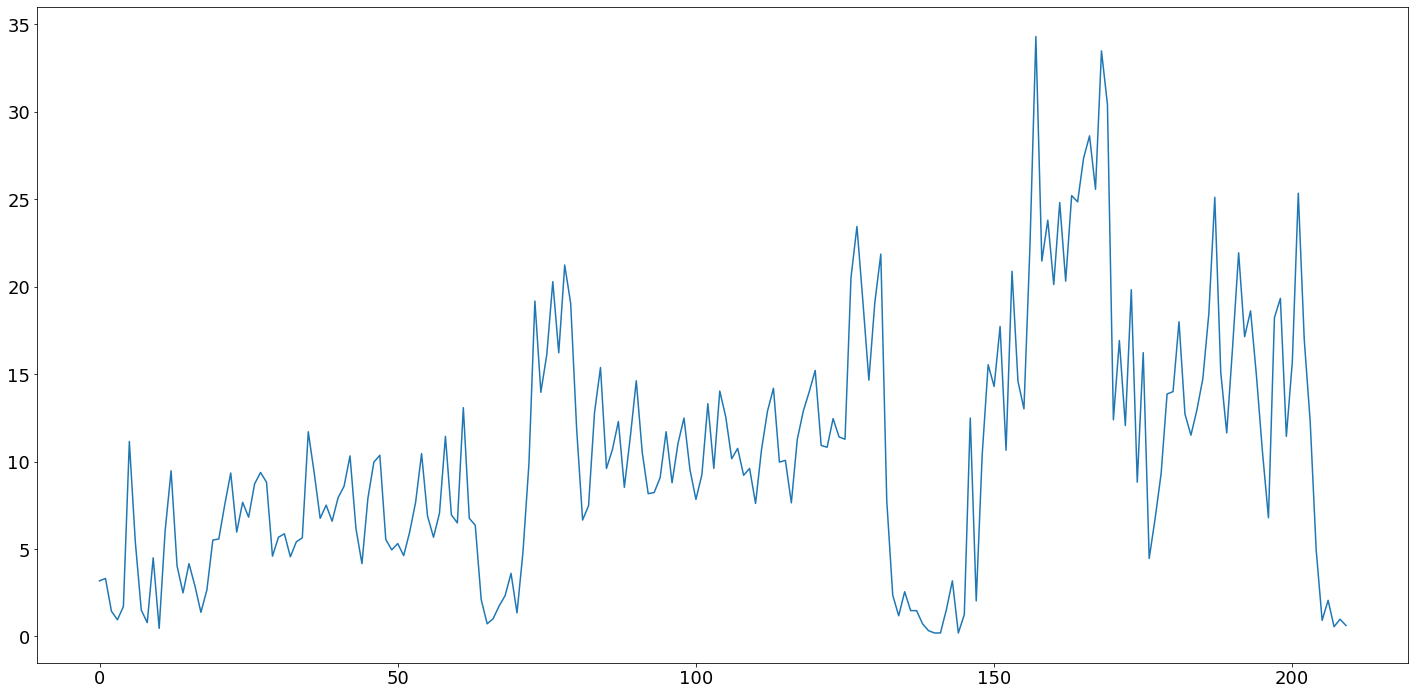

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


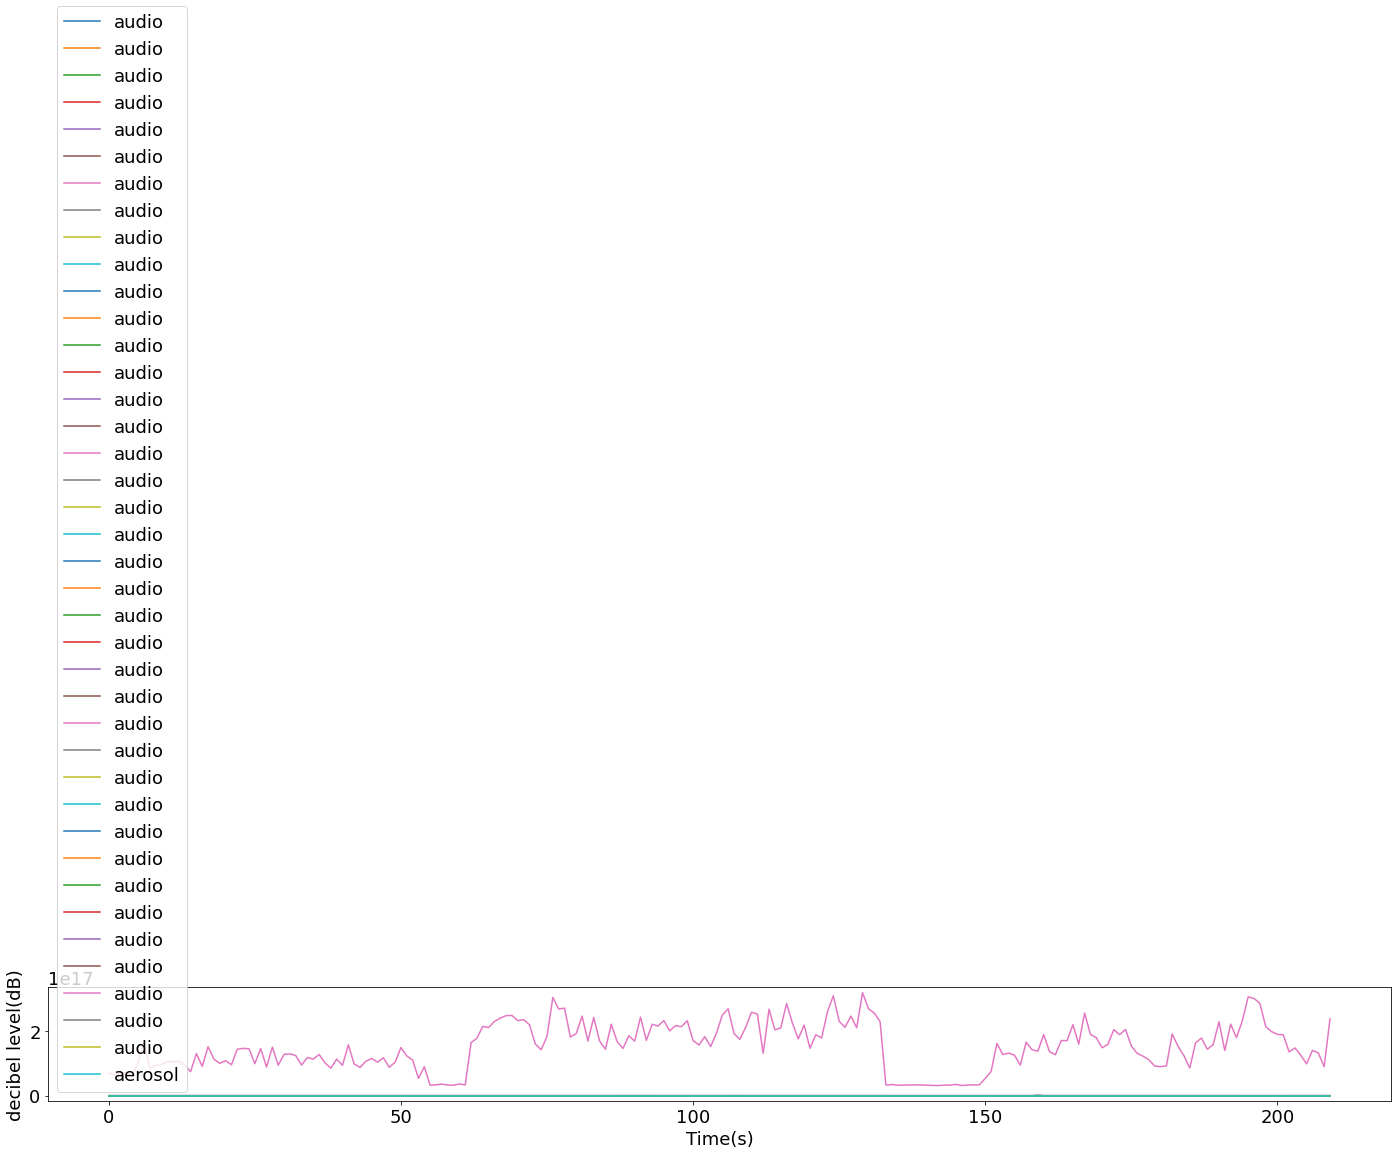

In [12]:
##get data from other file

var = pd.read_csv('exp_0415/mask_test_counting.csv')
df5 = var[85:]
# df4 = df4.drop('Sample #', 1)
# df4 = df4.drop('Sample Length', 1)
# df4 = df4.drop('Averaging Interval (s)', 1)
# df4 = df4.drop('Title', 1)
# df5 = df4[:-12]
df5 = df5.drop(df.index[(df['Start Time'] < "13:52")])
# plt.plot(df5['Conc Mean'])
temp = df5['Conc Mean'].tolist()[125:335]
plt.plot(temp)

print (len(temp))

samprate, wavdata = read('exp_0415/4-15-butanol_exp.wav')

dbs3 = []
WIDTH = 2

chunks = np.array_split(wavdata, 1544/6)
for chunk in chunks:
    print(chunk.shape)
    rms = audioop.rms(chunk, WIDTH) / 32767
    db = 20 * math.log10(rms)
    a,b,c = extract_features(chunk,samprate)
    dbs3.append(a)
# print(dbs)
dbs3 = dbs3[:210]

x = range(0,11600)
plt.figure(figsize=(20,10))
print(len(dbs3))

plt.plot(dbs3, label="audio")
plt.plot(temp, label="aerosol")
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("decibel level(dB)")
plt.savefig("audio_activities_415.png")


In [13]:
print(len(dbs3), len(temp))
print (len(dbs2[1:66]), len(df['Conc Mean'].tolist()[:65]))
print (len(dbs1[:-6]), len(df2['Conc Mean'].tolist()))
db = dbs2[1:66]+ dbs1[:-6] + dbs3[:145]
print(len(db))

df_temp = df['Conc Mean'].tolist()[:65] + df2['Conc Mean'].tolist() + temp[:145]

print(len(df_temp))

210 210
65 65
110 110
320
320


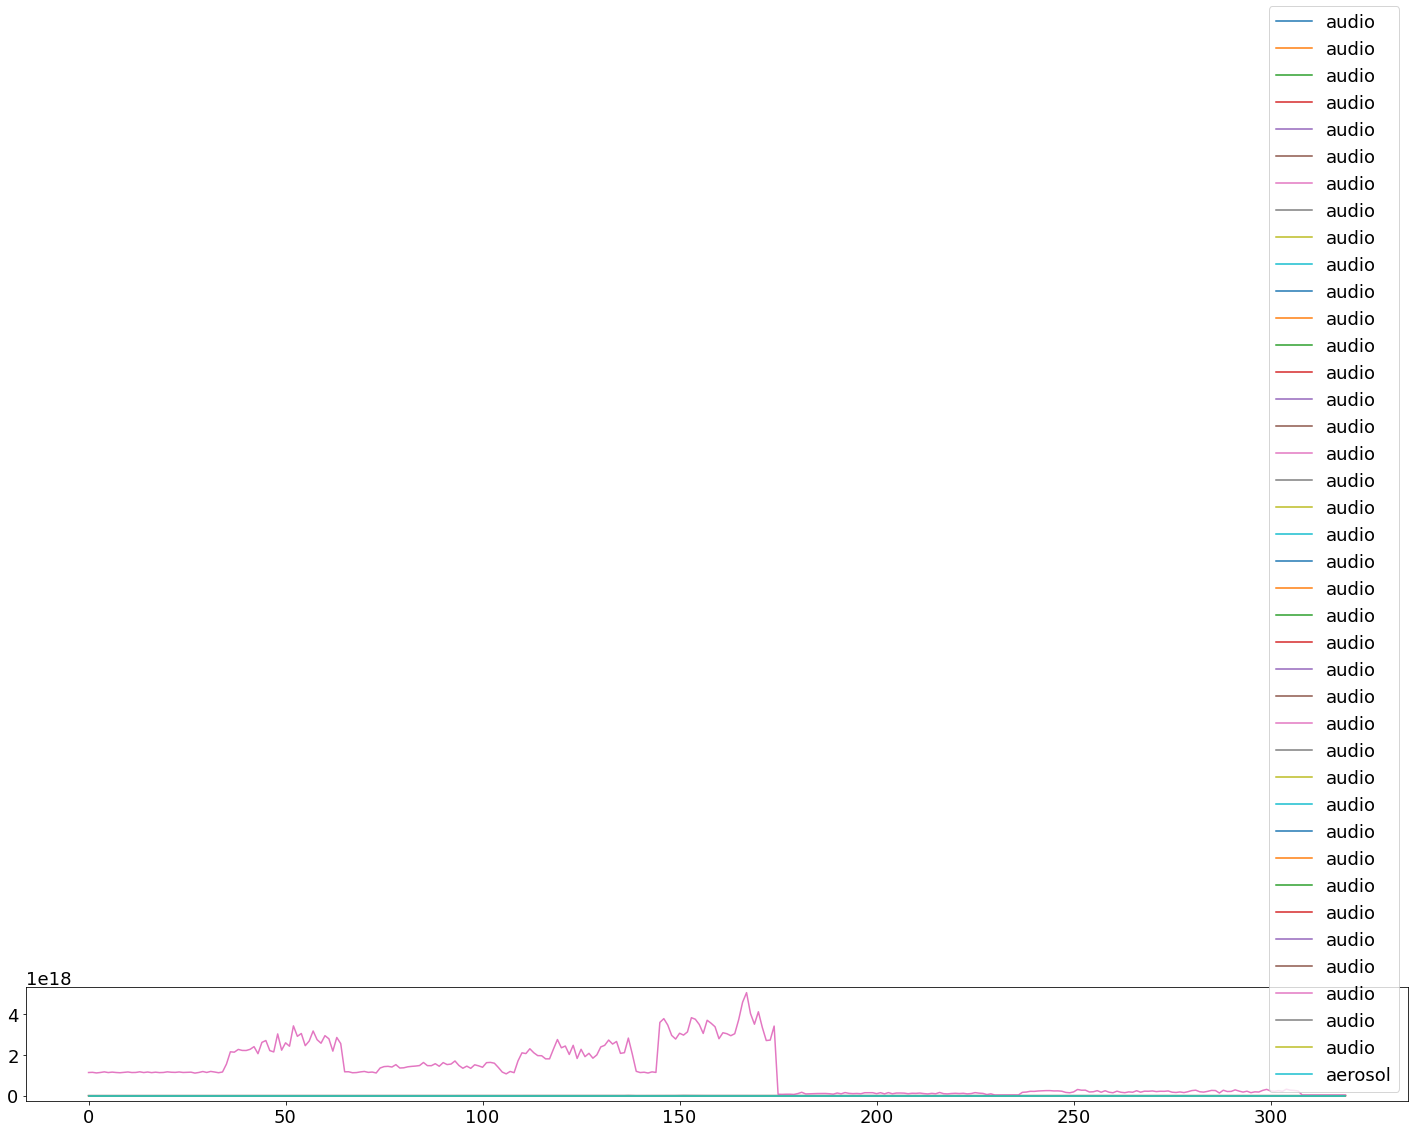

In [14]:
plt.plot(db, label="audio")
plt.plot(df_temp, label="aerosol")
plt.legend()



In [15]:
len(db[200])

39

Train Mean Squared Error: 0.9279548559080387
Regression score:  0.8708438093225107
Mean Absolute Error: 2.1199824022639104
Mean Squared Error: 10.755660822038331
Root Mean Squared Error: 3.279582415802099


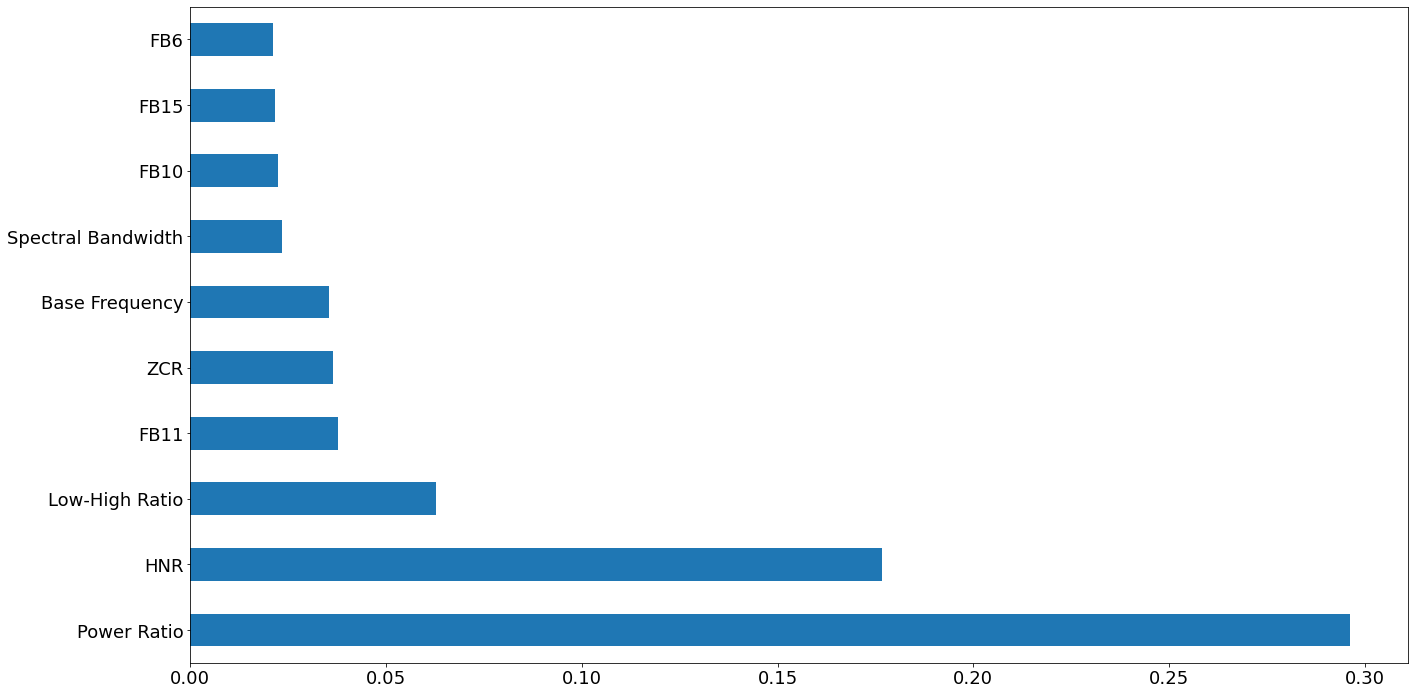

In [16]:
X = np.array(db , dtype=object)
y = np.array(df_temp)

from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
# reg = LinearRegression()
# reg.fit(X_train, y_train)
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



import pandas as pd
columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR", "FB1", "FB2", "FB3", "FB4", "FB5", "FB6", "FB7", "FB8", "FB9", "FB10" ] 
for i in range(10,26):
    columns.append("FB"+str(i+1))
feat_importances = pd.Series(reg.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))



print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Train Mean Squared Error: 12.26477620459011
Regression score:  0.4544731704234585
Mean Absolute Error: 2.5807535596939424
Mean Squared Error: 12.048292271800372
Root Mean Squared Error: 3.4710650054126577


In [18]:
from sklearn import svm

regr = svm.SVR(kernel='rbf', C=1, epsilon=0.1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Train Mean Squared Error: 17.740645231156996
Regression score:  0.22433116981494183
Mean Absolute Error: 3.0756882682081668
Mean Squared Error: 15.924260650830053
Root Mean Squared Error: 3.9905213507548174


(64, 39)

In [19]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_train_pred = regr.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


print ("Regression score: ", regr.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X_test.shape

Train Mean Squared Error: 4.299684659773333
Regression score:  0.7624673111537494
Mean Absolute Error: 2.0437818986619525
Mean Squared Error: 9.408576624371419
Root Mean Squared Error: 3.067340317664706


(64, 39)

Train Mean Squared Error: 2.256949153578792e-36
Regression score:  0.8422071320525816
Mean Absolute Error: 2.9896775
Mean Squared Error: 17.67522863567119
Root Mean Squared Error: 4.204191793397536


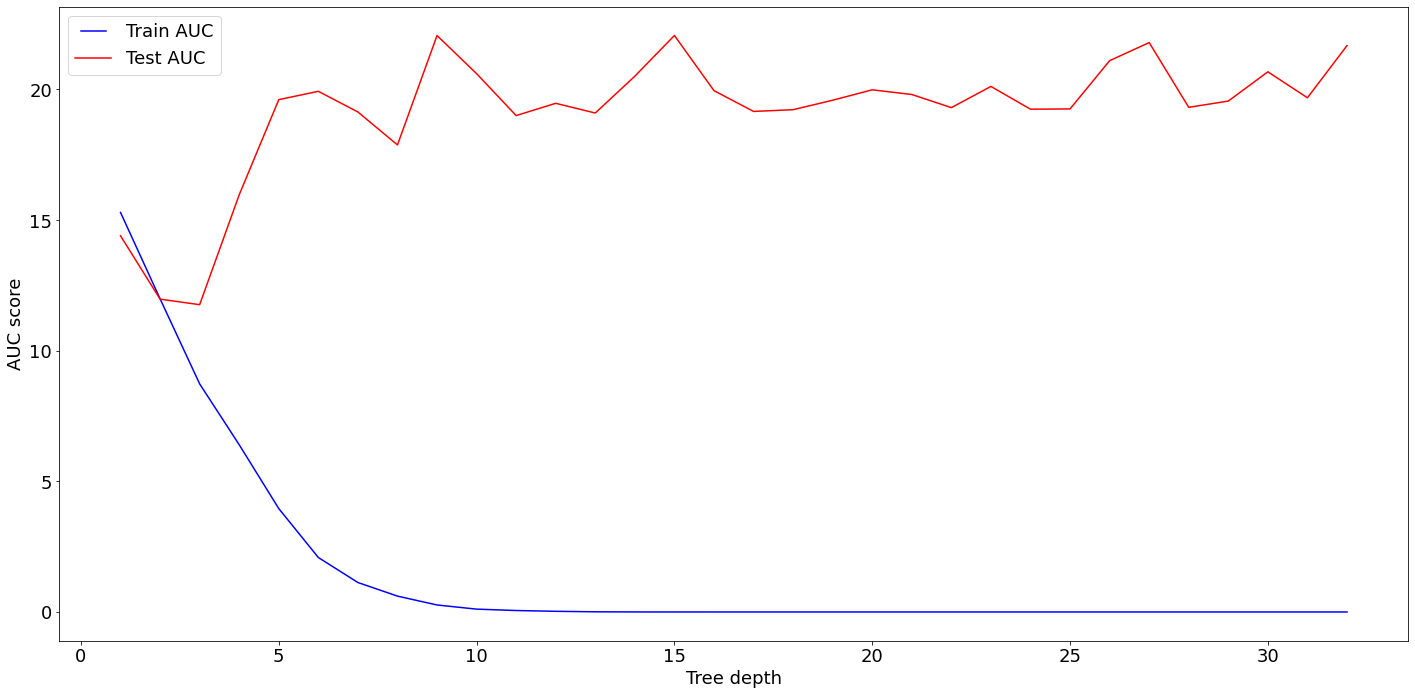

In [20]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))




print ("Regression score: ", clf.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


x_train = X_train
x_test = X_test
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = tree.DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   train_results.append(metrics.mean_squared_error(train_pred, y_train))
   y_pred = dt.predict(x_test)
   test_results.append(metrics.mean_squared_error(y_pred, y_test))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()



In [21]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.5, link='log')

reg.fit(X_train, y_train)


y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))


from sklearn import metrics
print ("Regression score: ", reg.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

X.shape

Train Mean Squared Error: 22.42885323971315
Regression score:  -0.00020211752549625928
Mean Absolute Error: 3.8005483447265633
Mean Squared Error: 22.324746931814985
Root Mean Squared Error: 4.724907081818116


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)


(320, 39)

In [22]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


[0.03923494 0.00829435 0.01626866 0.0116255  0.03868563 0.03722863
 0.0381227  0.02609334 0.02640256 0.13369106 0.01848797 0.05121583
 0.17691528 0.04026369 0.02337926 0.01410688 0.01214375 0.01336922
 0.01214211 0.00990433 0.00768796 0.01149713 0.01659978 0.01831821
 0.02143545 0.0155043  0.0158302  0.03609325 0.00919164 0.00922623
 0.0107184  0.00968021 0.0096387  0.01076359 0.01248356 0.00810347
 0.00937272 0.01019605 0.01008346]
Train Mean Squared Error: 9.497702991912311e-29
Regression score:  0.9135732796312702
Mean Absolute Error: 2.0267353043750003
Mean Squared Error: 9.681122237144258
Root Mean Squared Error: 3.111450182333675


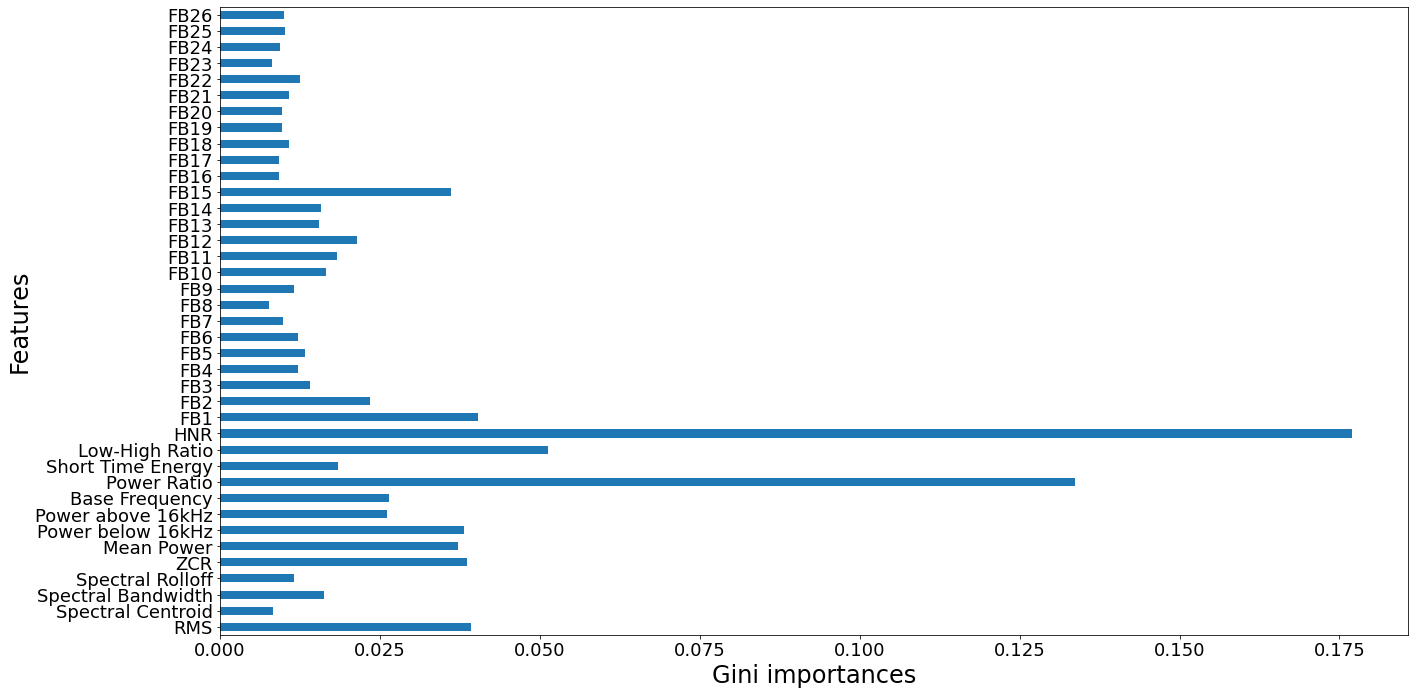

In [37]:
import pandas as pd
feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

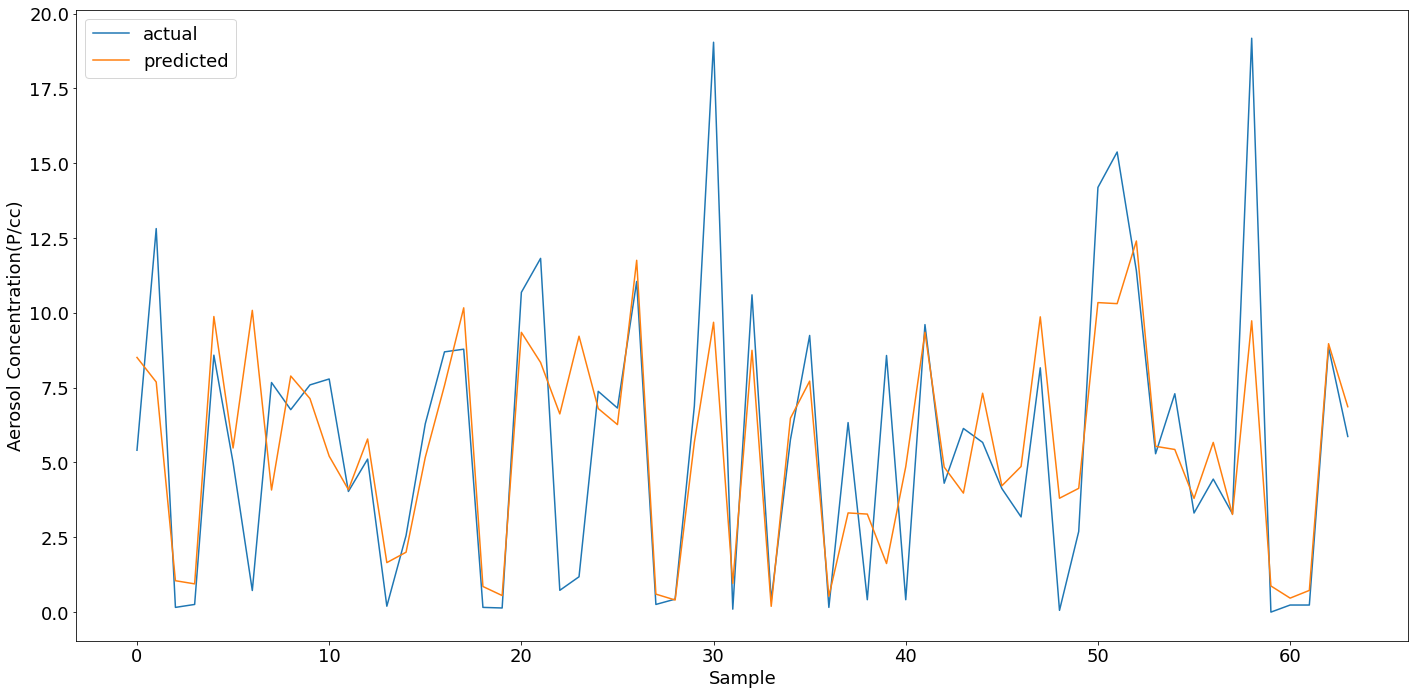

In [24]:
plt.plot(y_test, label="actual")
plt.plot(y_pred, label="predicted")
plt.ylabel("Aerosol Concentration(P/cc)")
plt.xlabel("Sample")
plt.legend()
plt.savefig("aerosol_predictions_GB.png")

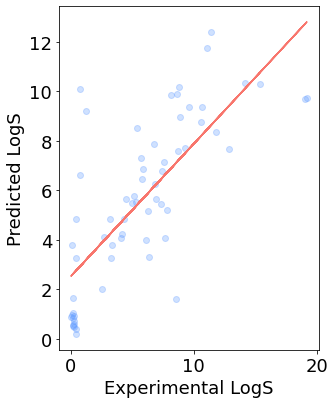

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,11))

plt.subplot(2, 1, 2)
plt.scatter(x=y_test, y=y_pred, c="#619CFF", alpha=0.3)

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_logS.pdf')
plt.show()

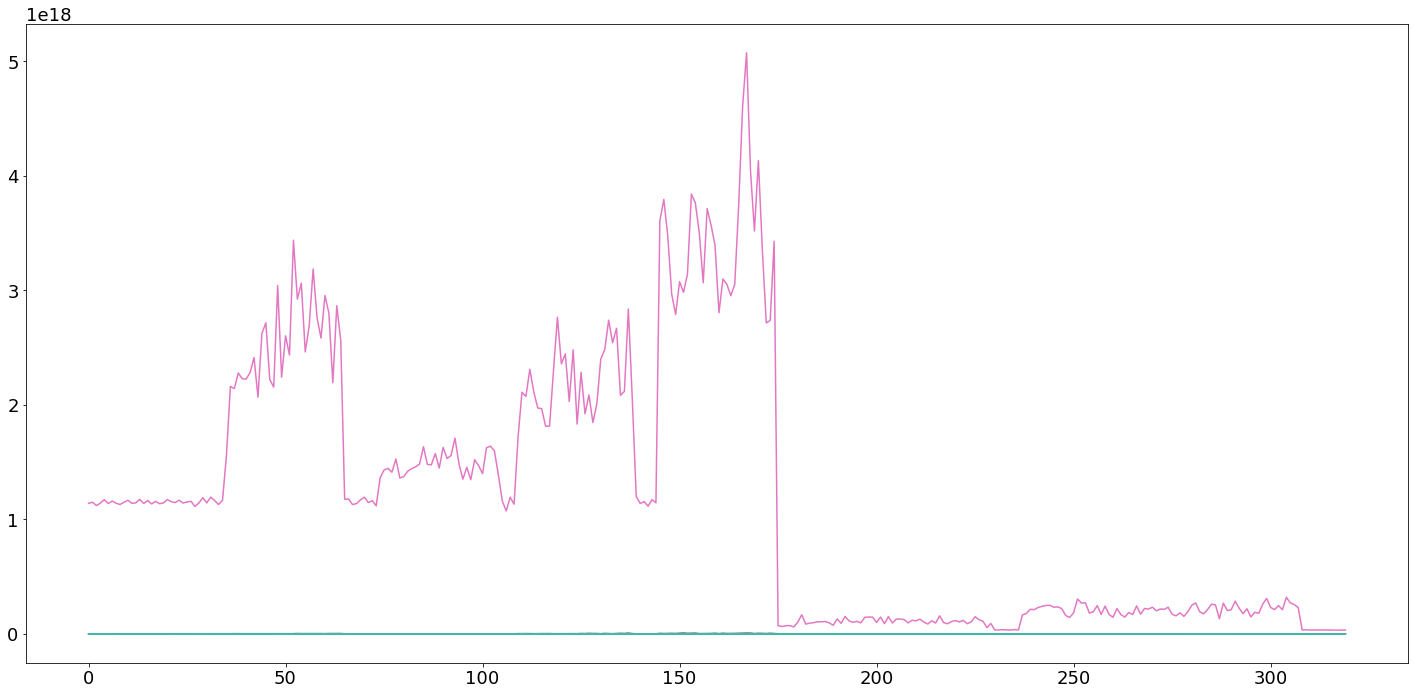

In [26]:
plt.plot(X)
plt.plot(y)

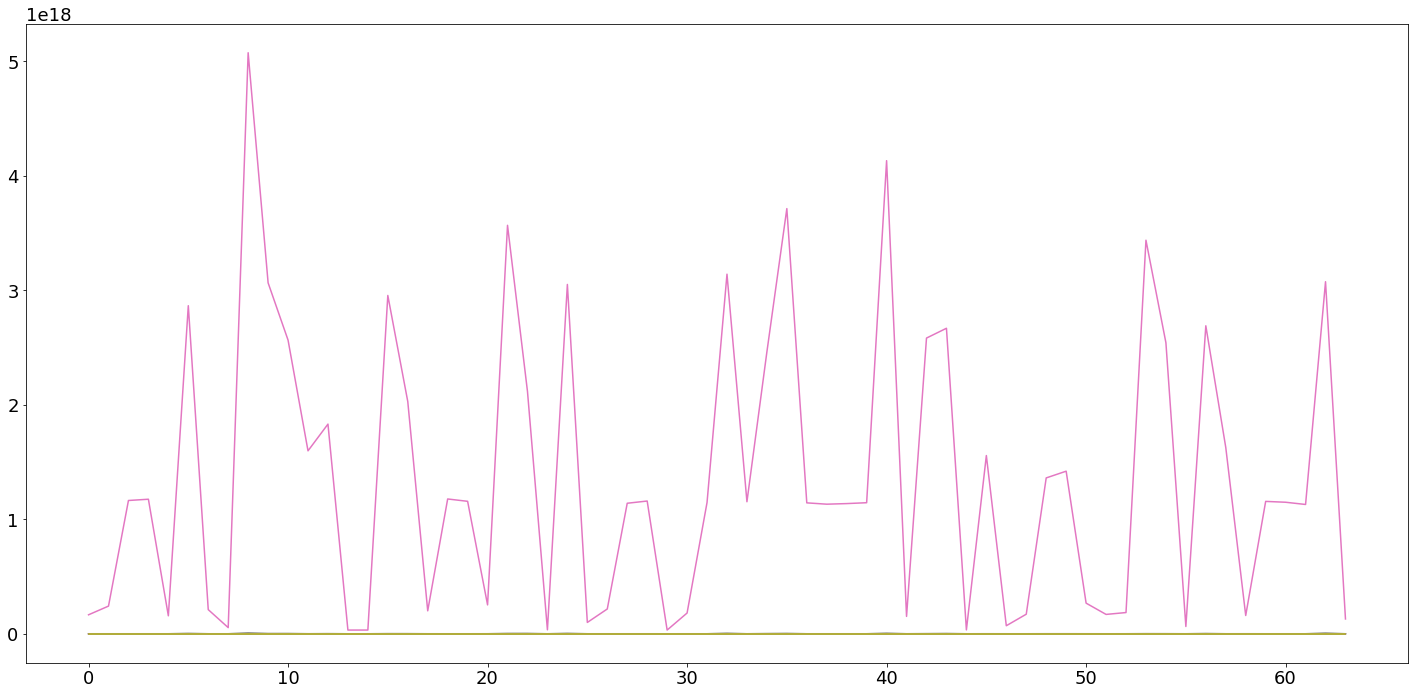

In [27]:
plt.plot(X_test)

In [28]:
low = []
med = [] 
high = []

y_low = []
y_med = []
y_high = []
for i in range(X_test.shape[0]):
    if X_test[i] >-20:
        high.append(X_test[i])
        y_high.append(y_test[i])
    elif X_test[i]<-20 and X_test[i]>-26.5:
        med.append(X_test[i])
        y_med.append(y_test[i])
    else:
        low.append(X_test[i])
        y_low.append(y_test[i])


print(X_test.shape[0],len(low), len(y_low)) 
low_pred = reg.predict(low)
med_pred = reg.predict(med)
high_pred = reg.predict(high)


# for i in range(len(low)):
#     low[i] = low[i][0]

    
# low = np.array(low)
# med = np.array(med)
# high = np.array(high)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
low = np.absolute(low_pred-y_low)
med = np.absolute(med_pred-y_med)
high = np.absolute(high_pred-y_high)
med = med[12:22] 

In [ ]:

low_mean = np.mean(low)
med_mean = np.mean(med)
high_mean = np.mean(high)


# low_mean2 = np.mean(low2)
# med_mean2 = np.mean(med2)
# high_mean2 = np.mean(high2)

# Calculate the standard deviation
low_std = np.std(low)
med_std = np.std(med)
high_std = np.std(high)

# low_std2 = np.std(low2)
# med_std2 = np.std(med2)
# high_std2 = np.std(high2)


# Define labels, positions, bar heights and error bar heights
labels = ['slow talking', 'medium talking', 'loud talking']
x_pos = np.arange(len(labels))
CTEs = [low_mean, med_mean, high_mean]
# CTEs2 = [low_mean2, med_mean2, high_mean2]
error = [low_std, med_std, high_std]
# error2 = [low_std2, med_std2, high_std2]

# Build the plot
fig, ax = plt.subplots(figsize=(9,7))
ax.bar(x_pos, CTEs,
       yerr=error,
       width=0.4,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10,label="Distance 70 inches")

# ax.bar(x_pos+0.2, CTEs2,
#        yerr=error2,
#        width=0.4,
#        align='center',
#        alpha=0.5,
#        ecolor='black',
#        capsize=10,
#       label="Distance 120 inches")
# ax.legend()
ax.set_ylabel('Absolute error(decibels)')
# ax.set_xlabel('Distance 70 inch')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('AP_error_bar.png')
plt.show()

In [ ]:
low

In [ ]:
med

In [ ]:
high

In [ ]:
plt.plot(low)
plt.plot(med)
plt.plot(high)

In [69]:
import numpy as np

df = pd.DataFrame(X, columns = columns)
df = df.astype(float)
# Create correlation matrix
corr_matrix = df.corr().abs()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
newdf = df.drop(to_drop, axis=1, inplace=True)

In [70]:
to_drop

['Spectral Bandwidth',
 'Spectral Rolloff',
 'Mean Power',
 'Power below 16kHz',
 'FB1',
 'FB2',
 'FB5',
 'FB6',
 'FB7',
 'FB8',
 'FB9',
 'FB10',
 'FB11',
 'FB12',
 'FB13',
 'FB14',
 'FB15',
 'FB16',
 'FB17',
 'FB18',
 'FB19',
 'FB20',
 'FB21',
 'FB22',
 'FB23',
 'FB24',
 'FB25',
 'FB26']

<Figure size 1368x1080 with 0 Axes>

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


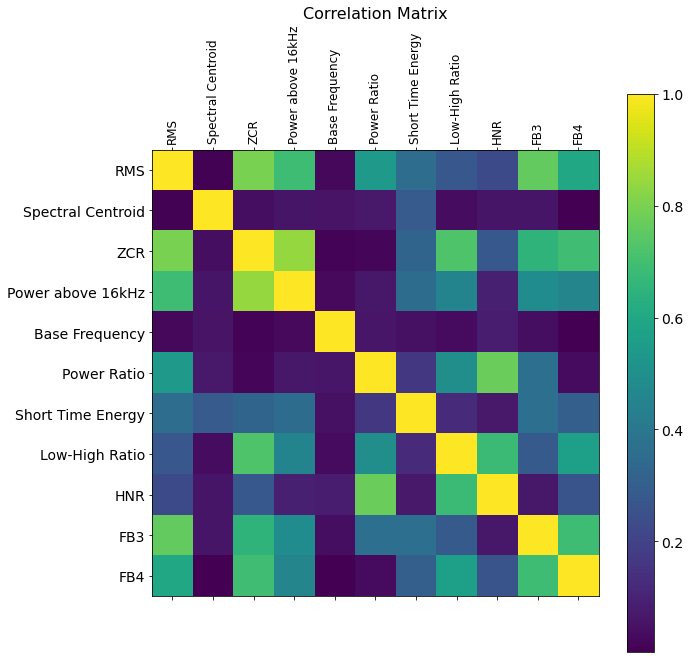

In [71]:
dff = plt.figure(figsize=(19, 15))
plt.matshow(df.corr().abs())
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [72]:
# corr_matrix.style.background_gradient(cmap='coolwarm')


In [73]:
# corr_matrix.shape

In [74]:
# df

In [75]:
# # df = np.
# df = df.astype(float)
# corr_matrix = df.corr().abs()
# high_corr_var=np.where(corr_matrix>0.9)
# high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [76]:
# corr_matrix
# corr_matrix.style.background_gradient(cmap='coolwarm')


In [77]:
# high_corr_var

Model Accuracy After Removing Correlated Features.

In [78]:
X_new = np.asarray(df)

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)


model = ExtraTreesRegressor(n_estimators=100)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

y_train_pred = model.predict(X_train)
print('Train Mean Squared Error:', metrics.mean_squared_error(y_train_pred, y_train))

from sklearn import metrics
print ("Regression score: ", model.score(X_new, y))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MAE: -11.971 (4.106)
[0.07556992 0.04268849 0.0717084  0.06297927 0.04359095 0.17978208
 0.05636646 0.11218891 0.26886608 0.04305338 0.04320606]
Train Mean Squared Error: 9.497702991912311e-29
Regression score:  0.915986324478136
Mean Absolute Error: 1.9495382840624997
Mean Squared Error: 9.410824092929692
Root Mean Squared Error: 3.0677066504034722


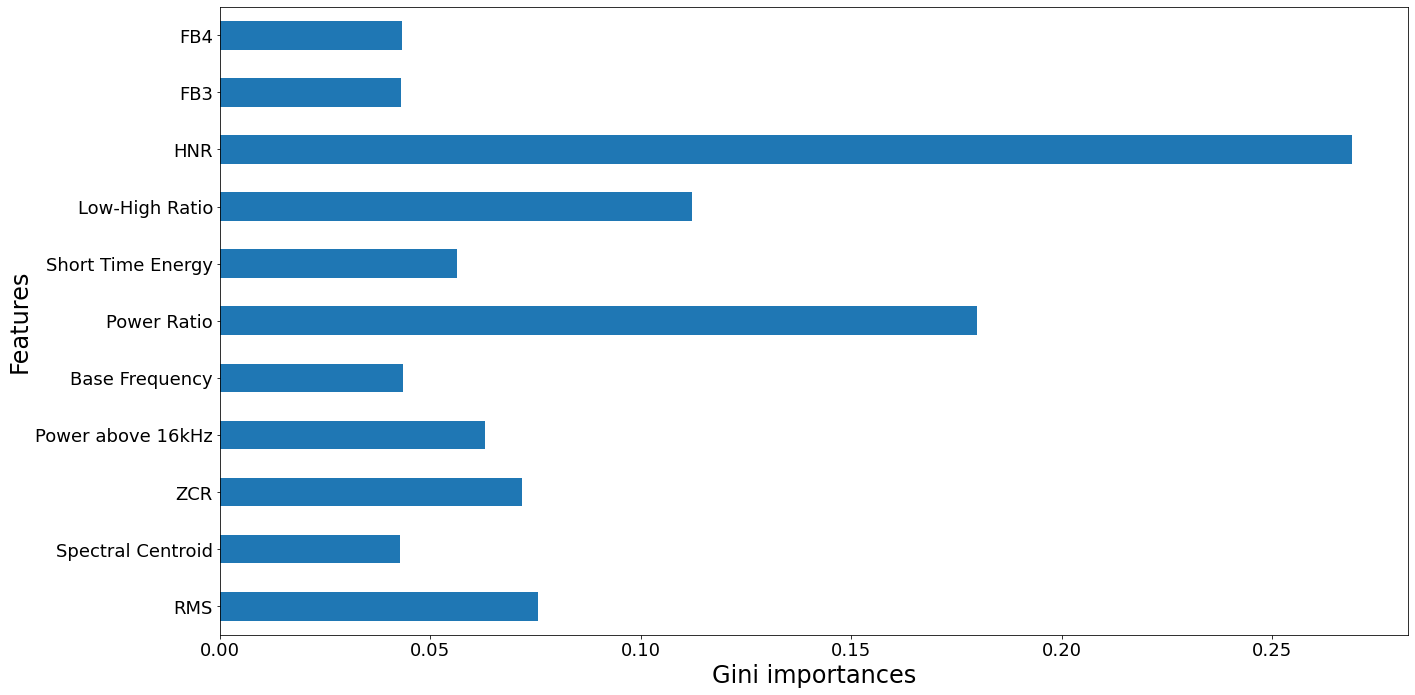

In [83]:
feat_importances = pd.Series(model.feature_importances_, index=df.columns)
feat_importances.plot(kind='barh', label=True)
plt.xlabel('Gini importances',fontsize=24)
plt.ylabel('Features', fontsize=24)
plt.show()

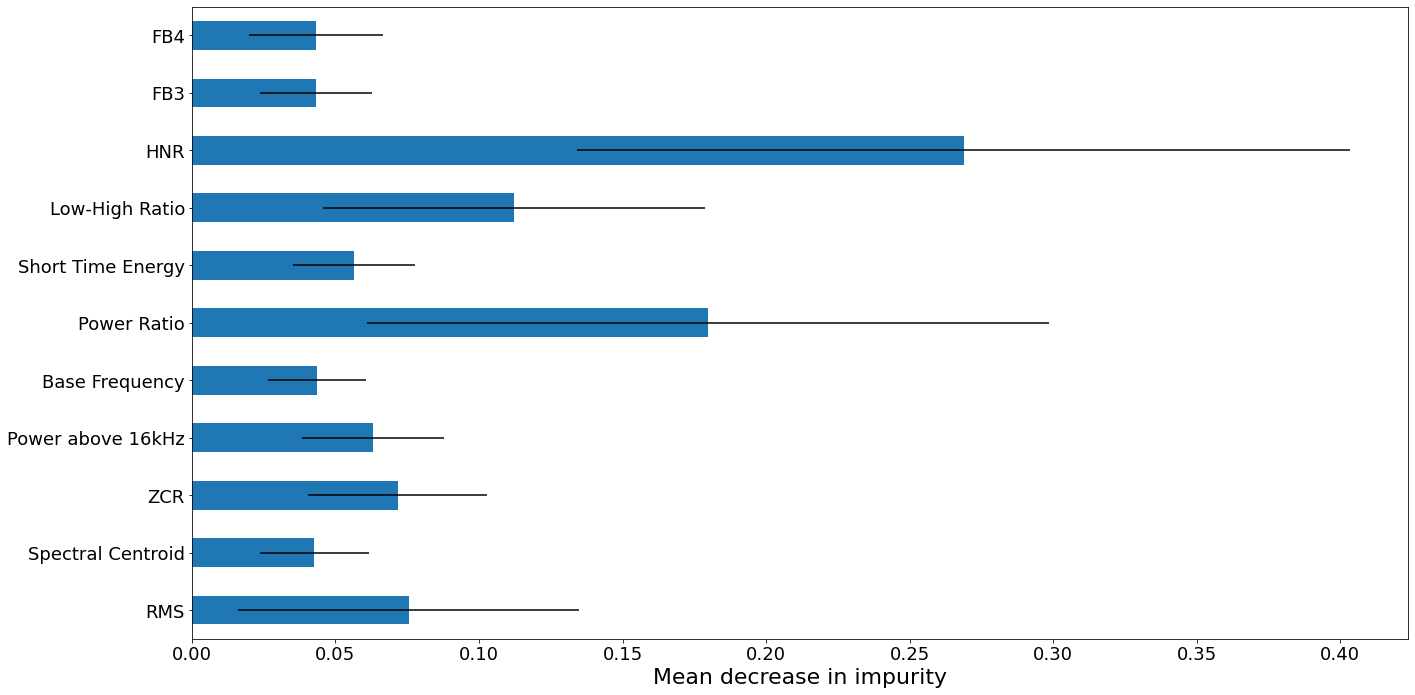

In [88]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.columns)
indices = np.argsort(importances)
# plt.figure()
# plt.barh(range(X_new.shape[1]), importances[indices], xerr=std[indices], align="center")
# # ax.set_title("Feature importances using MDI")
# plt.yticks(range(X_new.shape[1]), indices)
# plt.ylim([-1, X_new.shape[1]])
# plt.show()

forest_importances = pd.Series(importances, index=df.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity", fontsize=22)
fig.tight_layout()